Реализовать модель логистической регрессии. На базе шаблона 004-classification.ipynb необходимо реализовать операцию sigmoid в моделе логистической регрессии.
Решение необходимо прислать в виде ipython-ноутбука с визуализацией разделяющей гиперплоскости.

Статья о методах оптимизации нейронных сетей https://habr.com/ru/post/318970/

# Реализация логистической регрессии в TensorFlow

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

/Users/lera/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Генерируем данные для задачи регрессии

In [2]:
NUM_FEATURES = 2
NUM_SAMPLES = 1000

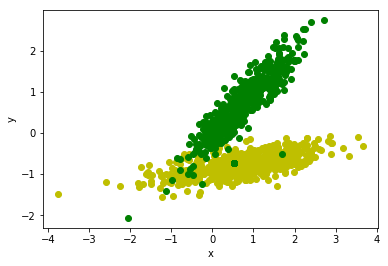

In [3]:
from sklearn.datasets import make_classification

X, y = make_classification(n_samples = NUM_SAMPLES,
                           n_features = NUM_FEATURES,
                           n_informative = NUM_FEATURES,
                           n_redundant = 0,
                           n_classes = 2,
                           n_clusters_per_class = 1,
                           class_sep = 0.75,
                           random_state = 54312)

y = y.reshape(-1, 1)

ones = np.where(y == 1)   # индексы объектов класса '1'
zeros = np.where(y == 0)  # индексы объектов класса '0'

plt.xlabel('x')
plt.ylabel('y')
plt.plot(X[ones, 0], X[ones, 1], 'oy',
         X[zeros, 0], X[zeros, 1], 'og');

In [4]:
X.shape

(1000, 2)

для того, чтобы добавить bias, необходимо добавить к features столбец единиц

In [5]:
ones_features = np.ones((X.shape[0], 1))
X = np.concatenate((X, ones_features), axis = 1)

In [6]:
X.shape

(1000, 3)

In [7]:
X

array([[ 0.53090065, -0.72111157,  1.        ],
       [ 0.15208848, -1.20929109,  1.        ],
       [ 0.07470638, -0.12826567,  1.        ],
       ...,
       [ 0.05947586, -0.05329481,  1.        ],
       [-0.1783635 , -0.46980986,  1.        ],
       [ 0.47776816, -0.74742666,  1.        ]])

### Вспомогательная функция для создания операций

In [8]:
import string

def py_func_with_grad(func, inp, Tout, grad, name = None, stateful = False, graph = None):
    
    name_prefix = ''.join(np.random.choice(list(string.ascii_letters), size = 10))
    
    name = '%s_%s' % (name_prefix, name or '')
    grad_func_name = '%s_grad' % name

    tf.RegisterGradient(grad_func_name)(grad)

    g = graph or tf.get_default_graph()
    with g.gradient_override_map({'PyFunc': grad_func_name, 
                                  'PyFuncStateless': grad_func_name}):
        with tf.name_scope(name, 'PyFuncOp', inp):
            return tf.py_func(func, inp, Tout, stateful = stateful, name = name)

### Реализация линейной операции

In [9]:
def linear_op_forward(X, W):
    ''' Реализация линейной операции '''
    return np.dot(X, W.T) # аргументы являются numpy-массивами

### Реализация вычисления градиента линейной операции

In [10]:
def linear_op_backward(op, grads):
    ''' Реализация вычисления градиента линейной операции '''
    X = op.inputs[0]  # тензор входных данных
    W = op.inputs[1]  # тензор параметров модели
    dX = tf.multiply(grads, W)
    dW = tf.reduce_sum(tf.multiply(X, grads),
                       axis = 0,
                       keep_dims = True)
    return dX, dW

### Реализация операции sigmoid

In [11]:
def sigmoid_op_forward(X):
    ''' Реализация операции sigmoid '''
    return 1.0 / (1.0 + np.exp(-X))

### Реализация вычисления градиента для sigmoid

In [12]:
def sigmoid_op_backward(op, grads):
    ''' Реализация вычисления градиента для sigmoid '''
    sigmoid = op.outputs[0]
    return sigmoid * (1 - sigmoid) * grads

## Создание графа вычислений и обучение модели (оптимизатор GradientDescentOptimizer)

In [13]:
weights = None  # в этой переменной мы сохраним результат обучения модели
learning_curve = []  # значения ошибки на каждой итерации обучения

with tf.Session(graph = tf.Graph()) as sess:  # инициализируем сессию вычислений
    
    # создаем placeholdr'ы, через них мы будем
    # передавать внешние данные в граф вычислений
    plh_X = tf.placeholder(dtype = tf.float32, shape = [None, NUM_FEATURES + 1])
    plh_labels = tf.placeholder(dtype = tf.float32, shape = [None, 1])

    # создаем переменную для хранения весов модели
    # эти веса будут изменяться в процессе обучения
    var_W = tf.Variable(tf.random_uniform(shape = [1, NUM_FEATURES + 1],
                                          dtype = tf.float32,
                                          seed = 54321))
    
    # создаем переменную для результата предсказания модели
    var_Pred = py_func_with_grad(linear_op_forward,         # функция предсказания модели 
                                 [plh_X, var_W],            # аргументы функции
                                 [tf.float32],              # тип выходных значений
                                 name = 'linear_op',        # имя операции 
                                 grad = linear_op_backward, # функция для вычисления градиента
                                 graph = sess.graph)        # объект графа вчислений
    
    # создаем переменную для результата операции sigmoid
    var_Sigmoid = py_func_with_grad(sigmoid_op_forward,
                                    [var_Pred],
                                    [tf.float32],
                                    name = 'sigmoid_op',
                                    grad = sigmoid_op_backward,
                                    graph = sess.graph)
    
    # кроссэнтропийная функция потерь для бинарной классификации
    cost = tf.losses.sigmoid_cross_entropy(plh_labels, var_Sigmoid)
    
    # инициализируем оптимизатор и указываем скорость обучения
    optimizer = tf.train.GradientDescentOptimizer(learning_rate = 0.01).minimize(cost)
    
    # инициализируем placeholder'ы и переменные
    sess.run(tf.global_variables_initializer())
    
    prev_loss = 0
    
    # выполняем итерации по 100000 эпохам
    for epoch in range(100000):
        
        # выполняем шаг обучения: вычисляем ошибку и обновляем веса
        loss, _ = sess.run([cost, optimizer],  # указываем, какие операции необходимо выполнить
                               feed_dict = {plh_X: X,  # передаем входные данные для вычисления
                                            plh_labels: y})
        
        # сохраняем значения ошибки для построения кривой обучения
        learning_curve.append(loss)
        
        # выводим текущее значение ошибки для каждого 1000го шага
        steps = len(learning_curve) - 1
        if steps % 1000 == 0:
            print('[%03d] loss=%.9f weights=%s' % (steps, loss, var_W.eval()))
            
        if abs (prev_loss - loss) < 0.00000001:
            break
            
        prev_loss = loss
        
    # сохраняем обученные веса
    weights = var_W.eval()

Instructions for updating:
keep_dims is deprecated, use keepdims instead
[000] loss=0.765455306 weights=[[0.42727858 0.2590521  0.24137697]]
[1000] loss=0.675424039 weights=[[ 0.16333814 -0.5850825  -0.09826852]]
[2000] loss=0.629658937 weights=[[ 0.09809747 -1.2167907  -0.30467737]]
[3000] loss=0.607915998 weights=[[ 0.15243708 -1.6631283  -0.4204783 ]]
[4000] loss=0.594302714 weights=[[ 0.2336385 -2.010599  -0.5113432]]
[5000] loss=0.584807396 weights=[[ 0.3160822  -2.2951367  -0.59469175]]
[6000] loss=0.577763021 weights=[[ 0.39334294 -2.5359297  -0.67444223]]
[7000] loss=0.572302878 weights=[[ 0.4643785 -2.744715  -0.7511669]]
[8000] loss=0.567927837 weights=[[ 0.5295705 -2.9291985 -0.8247633]]
[9000] loss=0.564331591 weights=[[ 0.5895895 -3.0946774 -0.8951059]]
[10000] loss=0.561314225 weights=[[ 0.64508533 -3.2449262  -0.96216536]]
[11000] loss=0.558740854 weights=[[ 0.69661874 -3.3827178  -1.0260025 ]]
[12000] loss=0.556516349 weights=[[ 0.7446576 -3.5101435 -1.0867385]]
[13000]

### Визуализирую кривую обучения

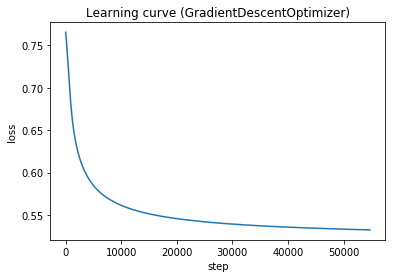

In [14]:
plt.xlabel('step')
plt.ylabel('loss')
plt.title('Learning curve (GradientDescentOptimizer)')
plt.plot(learning_curve);

### Визуализирую разделяющую гиперплоскость

In [15]:
weights

array([[ 1.612878 , -6.094115 , -2.3693485]], dtype=float32)

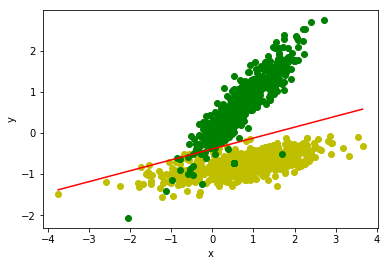

In [16]:
y_pred = - (X[:, 0] * weights[0, 0] + weights[0,2]) / weights[0, 1]

order = np.argsort(X[:, 0])

plt.xlabel('x')
plt.ylabel('y')
plt.plot(X[ones, 0], X[ones, 1], 'oy',
         X[zeros, 0], X[zeros, 1], 'og',
         X[order, 0], y_pred[order], '-r');

## Создание графа вычислений и обучение модели (оптимизатор MomentumOptimizer)

In [17]:
weights = None  # в этой переменной мы сохраним результат обучения модели
learning_curve = []  # значения ошибки на каждой итерации обучения

with tf.Session(graph = tf.Graph()) as sess:  # инициализируем сессию вычислений
    
    # создаем placeholdr'ы, через них мы будем
    # передавать внешние данные в граф вычислений
    plh_X = tf.placeholder(dtype = tf.float32, shape = [None, NUM_FEATURES + 1])
    plh_labels = tf.placeholder(dtype = tf.float32, shape = [None, 1])

    # создаем переменную для хранения весов модели
    # эти веса будут изменяться в процессе обучения
    var_W = tf.Variable(tf.random_uniform(shape = [1, NUM_FEATURES + 1],
                                          dtype = tf.float32,
                                          seed = 54321))
    
    # создаем переменную для результата предсказания модели
    var_Pred = py_func_with_grad(linear_op_forward,         # функция предсказания модели 
                                 [plh_X, var_W],            # аргументы функции
                                 [tf.float32],              # тип выходных значений
                                 name = 'linear_op',        # имя операции 
                                 grad = linear_op_backward, # функция для вычисления градиента
                                 graph = sess.graph)        # объект графа вчислений
    
    # создаем переменную для результата операции sigmoid
    var_Sigmoid = py_func_with_grad(sigmoid_op_forward,
                                    [var_Pred],
                                    [tf.float32],
                                    name = 'sigmoid_op',
                                    grad = sigmoid_op_backward,
                                    graph = sess.graph)
    
    # кроссэнтропийная функция потерь для бинарной классификации
    cost = tf.losses.sigmoid_cross_entropy(plh_labels, var_Sigmoid)
    
    # инициализируем оптимизатор и указываем скорость обучения
    optimizer = tf.train.MomentumOptimizer(learning_rate=0.01, momentum=0.9).minimize(cost)
    
    # инициализируем placeholder'ы и переменные
    sess.run(tf.global_variables_initializer())
    
    prev_loss = 0
    
    # выполняем итерации по 100000 эпохам
    for epoch in range(100000):
        
        # выполняем шаг обучения: вычисляем ошибку и обновляем веса
        loss, _ = sess.run([cost, optimizer],  # указываем, какие операции необходимо выполнить
                               feed_dict = {plh_X: X,  # передаем входные данные для вычисления
                                            plh_labels: y})
        
        # сохраняем значения ошибки для построения кривой обучения
        learning_curve.append(loss)
        
        # выводим текущее значение ошибки для каждого 1000го шага
        steps = len(learning_curve) - 1
        if steps % 1000 == 0:
            print('[%03d] loss=%.9f weights=%s' % (steps, loss, var_W.eval()))
            
        if abs (prev_loss - loss) < 0.00000001:
            break
            
        prev_loss = loss
        
    # сохраняем обученные веса
    weights = var_W.eval()

[000] loss=0.765455306 weights=[[0.42727858 0.2590521  0.24137697]]
[1000] loss=0.561222851 weights=[[ 0.64309657 -3.2544332  -0.9608012 ]]
[2000] loss=0.545553207 weights=[[ 1.0408248 -4.303609  -1.483713 ]]
[3000] loss=0.539166212 weights=[[ 1.2789615 -4.980998  -1.828263 ]]
[4000] loss=0.535565674 weights=[[ 1.442603  -5.497907  -2.0832074]]
[5000] loss=0.533200443 weights=[[ 1.5654066 -5.921554  -2.2872162]]
[6000] loss=0.531502008 weights=[[ 1.6633506 -6.2830677 -2.458769 ]]
[7000] loss=0.530209720 weights=[[ 1.7449238 -6.5998006 -2.607812 ]]
[8000] loss=0.529185534 weights=[[ 1.8150363 -6.882557  -2.7402494]]
[9000] loss=0.528348923 weights=[[ 1.8767262 -7.1385574 -2.8598661]]
[10000] loss=0.527649581 weights=[[ 1.9319806 -7.372892  -2.9692397]]
[11000] loss=0.527054369 weights=[[ 1.9821581 -7.589288  -3.0702112]]
[12000] loss=0.526539922 weights=[[ 2.0282257 -7.7905684 -3.1641436]]
[13000] loss=0.526089609 weights=[[ 2.0708926 -7.9789186 -3.2520778]]
[14000] loss=0.525691450 wei

### Визуализирую кривую обучения

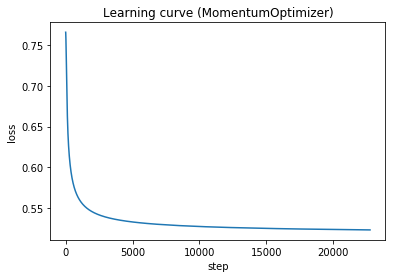

In [18]:
plt.xlabel('step')
plt.ylabel('loss')
plt.title('Learning curve (MomentumOptimizer)')
plt.plot(learning_curve);

### Визуализирую разделяющую гиперплоскость

In [19]:
weights

array([[ 2.3812869, -9.384754 , -3.910444 ]], dtype=float32)

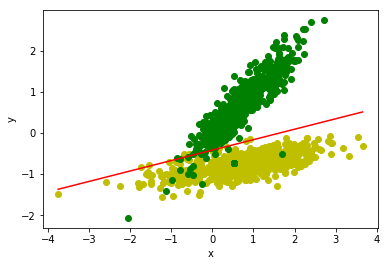

In [20]:
y_pred = - (X[:, 0] * weights[0, 0] + weights[0,2]) / weights[0, 1]

order = np.argsort(X[:, 0])

plt.xlabel('x')
plt.ylabel('y')
plt.plot(X[ones, 0], X[ones, 1], 'oy',
         X[zeros, 0], X[zeros, 1], 'og',
         X[order, 0], y_pred[order], '-r');

## Создание графа вычислений и обучение модели (оптимизатор AdamOptimizer)

In [21]:
weights = None  # в этой переменной мы сохраним результат обучения модели
learning_curve = []  # значения ошибки на каждой итерации обучения

with tf.Session(graph = tf.Graph()) as sess:  # инициализируем сессию вычислений
    
    # создаем placeholdr'ы, через них мы будем
    # передавать внешние данные в граф вычислений
    plh_X = tf.placeholder(dtype = tf.float32, shape = [None, NUM_FEATURES + 1])
    plh_labels = tf.placeholder(dtype = tf.float32, shape = [None, 1])

    # создаем переменную для хранения весов модели
    # эти веса будут изменяться в процессе обучения
    var_W = tf.Variable(tf.random_uniform(shape = [1, NUM_FEATURES + 1],
                                          dtype = tf.float32,
                                          seed = 54321))
    
    # создаем переменную для результата предсказания модели
    var_Pred = py_func_with_grad(linear_op_forward,         # функция предсказания модели 
                                 [plh_X, var_W],            # аргументы функции
                                 [tf.float32],              # тип выходных значений
                                 name = 'linear_op',        # имя операции 
                                 grad = linear_op_backward, # функция для вычисления градиента
                                 graph = sess.graph)        # объект графа вчислений
    
    # создаем переменную для результата операции sigmoid
    var_Sigmoid = py_func_with_grad(sigmoid_op_forward,
                                    [var_Pred],
                                    [tf.float32],
                                    name = 'sigmoid_op',
                                    grad = sigmoid_op_backward,
                                    graph = sess.graph)
    
    # кроссэнтропийная функция потерь для бинарной классификации
    cost = tf.losses.sigmoid_cross_entropy(plh_labels, var_Sigmoid)
    
    # инициализируем оптимизатор и указываем скорость обучения
    
    optimizer = tf.train.AdamOptimizer(learning_rate=0.01, beta1=0.9, beta2=0.999, epsilon=1e-08,).minimize(cost)
    
    # инициализируем placeholder'ы и переменные
    sess.run(tf.global_variables_initializer())
    
    prev_loss = 0
    
    # выполняем итерации по 100000 эпохам
    for epoch in range(100000):
        
        # выполняем шаг обучения: вычисляем ошибку и обновляем веса
        loss, _ = sess.run([cost, optimizer],  # указываем, какие операции необходимо выполнить
                               feed_dict = {plh_X: X,  # передаем входные данные для вычисления
                                            plh_labels: y})
        
        # сохраняем значения ошибки для построения кривой обучения
        learning_curve.append(loss)
        
        # выводим текущее значение ошибки для каждого 1000го шага
        steps = len(learning_curve) - 1
        if steps % 1000 == 0:
            print('[%03d] loss=%.9f weights=%s' % (steps, loss, var_W.eval()))
            
        if abs (prev_loss - loss) < 0.00000001:
            break
            
        prev_loss = loss
        
    # сохраняем обученные веса
    weights = var_W.eval()

[000] loss=0.765455306 weights=[[0.41748944 0.24982694 0.23166512]]
[1000] loss=0.540694952 weights=[[ 1.4909647 -4.6898365 -1.9671052]]
[2000] loss=0.528835177 weights=[[ 1.9579563 -6.9434824 -2.9068635]]
[3000] loss=0.524362862 weights=[[ 2.3295348 -8.806556  -3.7378047]]
[4000] loss=0.521960199 weights=[[  2.6908448 -10.576409   -4.549811 ]]
[5000] loss=0.520467818 weights=[[  3.0645    -12.364808   -5.3821545]]
[6000] loss=0.519471586 weights=[[  3.4608476 -14.230584   -6.258078 ]]
[7000] loss=0.518780470 weights=[[  3.8850853 -16.20994    -7.1935744]]
[8000] loss=0.518291414 weights=[[  4.3385983 -18.327677   -8.201331 ]]
[9000] loss=0.517940640 weights=[[  4.8187394 -20.604197   -9.293882 ]]
[10000] loss=0.517685652 weights=[[  5.318015 -23.063364 -10.487478]]
[11000] loss=0.517495871 weights=[[  5.82636  -25.746151 -11.807343]]


### Визуализирую кривую обучения

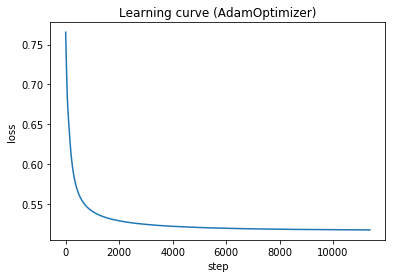

In [22]:
plt.xlabel('step')
plt.ylabel('loss')
plt.title('Learning curve (AdamOptimizer)')
plt.plot(learning_curve);

### Визуализирую разделяющую гиперплоскость

In [23]:
weights

array([[  6.0253086, -26.859566 , -12.359711 ]], dtype=float32)

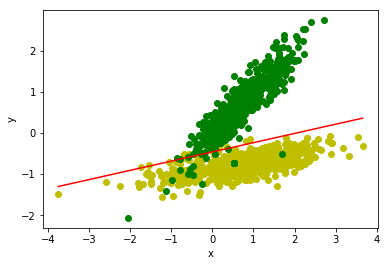

In [24]:
y_pred = - (X[:, 0] * weights[0, 0] + weights[0,2]) / weights[0, 1]

order = np.argsort(X[:, 0])

plt.xlabel('x')
plt.ylabel('y')
plt.plot(X[ones, 0], X[ones, 1], 'oy',
         X[zeros, 0], X[zeros, 1], 'og',
         X[order, 0], y_pred[order], '-r');

## Создание графа вычислений и обучение модели (оптимизатор RMSPropOptimizer)

In [25]:
weights = None  # в этой переменной мы сохраним результат обучения модели
learning_curve = []  # значения ошибки на каждой итерации обучения

with tf.Session(graph = tf.Graph()) as sess:  # инициализируем сессию вычислений
    
    # создаем placeholdr'ы, через них мы будем
    # передавать внешние данные в граф вычислений
    plh_X = tf.placeholder(dtype = tf.float32, shape = [None, NUM_FEATURES + 1])
    plh_labels = tf.placeholder(dtype = tf.float32, shape = [None, 1])

    # создаем переменную для хранения весов модели
    # эти веса будут изменяться в процессе обучения
    var_W = tf.Variable(tf.random_uniform(shape = [1, NUM_FEATURES + 1],
                                          dtype = tf.float32,
                                          seed = 54321))
    
    # создаем переменную для результата предсказания модели
    var_Pred = py_func_with_grad(linear_op_forward,         # функция предсказания модели 
                                 [plh_X, var_W],            # аргументы функции
                                 [tf.float32],              # тип выходных значений
                                 name = 'linear_op',        # имя операции 
                                 grad = linear_op_backward, # функция для вычисления градиента
                                 graph = sess.graph)        # объект графа вчислений
    
    # создаем переменную для результата операции sigmoid
    var_Sigmoid = py_func_with_grad(sigmoid_op_forward,
                                    [var_Pred],
                                    [tf.float32],
                                    name = 'sigmoid_op',
                                    grad = sigmoid_op_backward,
                                    graph = sess.graph)
    
    # кроссэнтропийная функция потерь для бинарной классификации
    cost = tf.losses.sigmoid_cross_entropy(plh_labels, var_Sigmoid)
    
    # инициализируем оптимизатор и указываем скорость обучения
    optimizer = tf.train.RMSPropOptimizer(learning_rate = 0.01, decay=0.9, momentum=0.0, epsilon=1e-10,).minimize(cost)
    
    # инициализируем placeholder'ы и переменные
    sess.run(tf.global_variables_initializer())
    
    prev_loss = 0
    
    # выполняем итерации по 100000 эпохам
    for epoch in range(100000):
        
        # выполняем шаг обучения: вычисляем ошибку и обновляем веса
        loss, _ = sess.run([cost, optimizer],  # указываем, какие операции необходимо выполнить
                               feed_dict = {plh_X: X,  # передаем входные данные для вычисления
                                            plh_labels: y})
        
        # сохраняем значения ошибки для построения кривой обучения
        learning_curve.append(loss)
        
        # выводим текущее значение ошибки для каждого 1000го шага
        steps = len(learning_curve) - 1
        if steps % 1000 == 0:
            print('[%03d] loss=%.9f weights=%s' % (steps, loss, var_W.eval()))
            
        if abs (prev_loss - loss) < 0.00000001:
            break
            
        prev_loss = loss
        
    # сохраняем обученные веса
    weights = var_W.eval()

[000] loss=0.765455306 weights=[[0.4272672  0.25901046 0.2413614 ]]
[1000] loss=0.523988008 weights=[[ 2.3935616 -9.035445  -3.862187 ]]
[2000] loss=0.518203616 weights=[[  4.445354 -18.823792  -8.445423]]
[3000] loss=0.517354548 weights=[[  6.321547 -28.58163  -13.213472]]
[4000] loss=0.517080843 weights=[[  7.900038 -37.815636 -17.789154]]


### Визуализирую кривую обучения

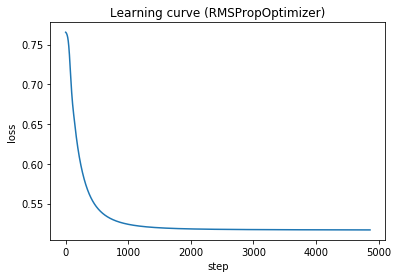

In [26]:
plt.xlabel('step')
plt.ylabel('loss')
plt.title('Learning curve (RMSPropOptimizer)')
plt.plot(learning_curve);

### Визуализирую разделяющую гиперплоскость

In [27]:
weights

array([[  9.184014, -44.96468 , -21.291374]], dtype=float32)

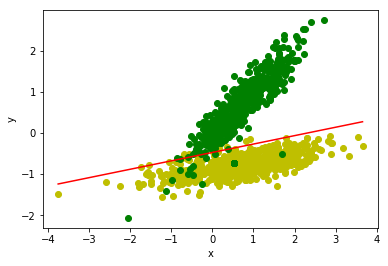

In [28]:
y_pred = - (X[:, 0] * weights[0, 0] + weights[0,2]) / weights[0, 1]

order = np.argsort(X[:, 0])

plt.xlabel('x')
plt.ylabel('y')
plt.plot(X[ones, 0], X[ones, 1], 'oy',
         X[zeros, 0], X[zeros, 1], 'og',
         X[order, 0], y_pred[order], '-r');

По мои ощущениям эта работа оказалась для меня самой сложной из-за отсутсвия опыта работы с TensorFlow. Порекомендуйте, пожалуйста, полезные материалы для быстрого освоения TensorFlow.